In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time
import torch
import random
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

2025-06-01 13:41:46.842020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748785307.050111      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748785307.117877      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Train from scratch for each dataset

In [2]:
output_base = "/kaggle/working/roberta_train_combined"
num_epochs = 20
batch_size = 64
max_length = 128
learning_rate = 2e-5
base_model = "roberta-base"
early_stopping_patience = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
'''
# ======================= CONFIG ========================

datasets = {
    "Covid-19": {
        "train": "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv",
        "val": "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv",
        "test": "/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv"
    },
    "GossipCop": {
        "train": "/kaggle/input/ml-20242-g1/gossipcop_train.csv",
        "val": "/kaggle/input/ml-20242-g1/gossipcop_val.csv",
        "test": "/kaggle/input/ml-20242-g1/gossipcop_test.csv"
    },
    "Politifact": {
        "train": "/kaggle/input/ml-20242-g1/politifact_train.csv",
        "val": "/kaggle/input/ml-20242-g1/politifact_val.csv",
        "test": "/kaggle/input/ml-20242-g1/politifact_test.csv"
    },
    "Liar": {
        "train": "/kaggle/input/ml-20242-g1/liar_train_covid_format.csv",
        "val": "/kaggle/input/ml-20242-g1/liar_valid_covid_format.csv",
        "test": "/kaggle/input/ml-20242-g1/liar_test_covid_format.csv"
    }
}

# =================== HELPER FUNCTIONS ===================

def prep_df(df):
    df = df[['tweet', 'label']].copy()
    df.columns = ['Text', 'Label']
    df['Label'] = df['Label'].map({'real': 0, 'fake': 1})
    return df

def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['Text']), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    labels = torch.tensor(df['Label'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

def evaluate_model(model, val_loader, loss_fn):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    
    with torch.inference_mode():
        for batch in tqdm(val_loader, desc="Evaluating", leave=True):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attn_mask, labels = batch
            outputs = model(input_ids, attention_mask=attn_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return avg_loss, acc, prec, rec, f1, all_preds, all_labels

# =================== MAIN TRAINING LOOP ===================
def main():
    its_with_class_weight = ['GossipCop', 'Politifact', 'Liar']
    os.makedirs(output_base, exist_ok=True)

    for dataset_name, dataset_paths in datasets.items():
        print(f"\n ------ Training fresh model on: {dataset_name} ------ ")
    
        # Load and prepare data
        train_df = prep_df(pd.read_csv(dataset_paths["train"]))
        val_df = prep_df(pd.read_csv(dataset_paths["val"]))
        test_df = prep_df(pd.read_csv(dataset_paths["test"]))

        # Conditional class weight
        if dataset_name in its_with_class_weight:
            class_weights = compute_class_weight(
                class_weight="balanced",
                classes=np.array([0, 1]),
                y=train_df['Label'].values
            )
            class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
            loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
            print(f"Class weights applied for {dataset_name}: {class_weights}")
        else:
            loss_fn = torch.nn.CrossEntropyLoss()
            print(f"No class weights applied for {dataset_name} since dataset is balanced.")
    
        tokenizer = RobertaTokenizer.from_pretrained(base_model)
        train_data = encode_data(train_df, tokenizer)
        val_data = encode_data(val_df, tokenizer)
        test_data = encode_data(test_df, tokenizer)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size)
        test_loader = DataLoader(test_data, batch_size=batch_size)
    
        model = RobertaForSequenceClassification.from_pretrained(base_model, num_labels=2).to(device)
    
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
        total_steps = len(train_loader) * num_epochs
        warmup_steps = int(0.1 * total_steps)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
        best_val_acc = 0.0
        patience_counter = 0
        best_model_state = None
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            model.train()
            total_train_loss = 0
        
            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
                batch = tuple(t.to(device) for t in batch)
                input_ids, attn_mask, labels = batch
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attn_mask)
                loss = loss_fn(outputs.logits, labels)
                loss.backward()
                total_train_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
        
            avg_train_loss = total_train_loss / len(train_loader)
            print(f"Training Loss: {avg_train_loss:.4f}")
        
            val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate_model(model, val_loader, loss_fn)
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Validation Precision: {val_prec:.4f}")
            print(f"Validation Recall: {val_rec:.4f}")
            print(f"Validation F1-score: {val_f1:.4f}")
        
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = model.state_dict()
                print("New best model found.")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{early_stopping_patience}")
                if patience_counter >= early_stopping_patience:
                    print("Early stopping.")
                    break
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            os.makedirs(output_base, exist_ok=True)
            torch.save(best_model_state, f"{output_base}/{dataset_name}_model.pt")
            print(f"Best model saved to {output_base}/{dataset_name}_model.pt")
        
        # Evaluation on Test Set
        test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate_model(model, test_loader, loss_fn)
        print(f"\nTest Set of {dataset_name}:")
        print(f"  Loss:     {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.4f}")
        print(f"  Precision:{test_prec:.4f}")
        print(f"  Recall:   {test_rec:.4f}")
        print(f"  F1-score: {test_f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(test_labels, test_preds)
        cm_df = pd.DataFrame(cm, index=["Real", "Fake"], columns=["Real", "Fake"])
        print("\nConfusion Matrix:")
        
        # Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{output_base}/{dataset_name}_cm.png', dpi=200)
        plt.close()

        model_dir = os.path.join(output_base, f"{dataset_name}_checkpoint")
        os.makedirs(model_dir, exist_ok=True)
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)

    print("\nAll models trained and saved.")

if __name__ == "__main__":
    main()
'''

'\n# ======================= CONFIG ========================\n\ndatasets = {\n    "Covid-19": {\n        "train": "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv",\n        "val": "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv",\n        "test": "/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv"\n    },\n    "GossipCop": {\n        "train": "/kaggle/input/ml-20242-g1/gossipcop_train.csv",\n        "val": "/kaggle/input/ml-20242-g1/gossipcop_val.csv",\n        "test": "/kaggle/input/ml-20242-g1/gossipcop_test.csv"\n    },\n    "Politifact": {\n        "train": "/kaggle/input/ml-20242-g1/politifact_train.csv",\n        "val": "/kaggle/input/ml-20242-g1/politifact_val.csv",\n        "test": "/kaggle/input/ml-20242-g1/politifact_test.csv"\n    },\n    "Liar": {\n        "train": "/kaggle/input/ml-20242-g1/liar_train_covid_format.csv",\n        "val": "/kaggle/input/ml-20242-g1/liar_valid_covid_format.csv",\n        "test": "/kaggle

# Train combined

In [4]:
import pandas as pd
import os

datasets = {
    "Covid-19": {
        "train": "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv",
        "val": "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv",
        "test": "/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv"
    },
    "GossipCop": {
        "train": "/kaggle/input/ml-20242-g1/gossipcop_train.csv",
        "val": "/kaggle/input/ml-20242-g1/gossipcop_val.csv",
        "test": "/kaggle/input/ml-20242-g1/gossipcop_test.csv"
    },
    "Politifact": {
        "train": "/kaggle/input/ml-20242-g1/politifact_train.csv",
        "val": "/kaggle/input/ml-20242-g1/politifact_val.csv",
        "test": "/kaggle/input/ml-20242-g1/politifact_test.csv"
    },
    "Liar": {
        "train": "/kaggle/input/ml-20242-g1/liar_train_covid_format.csv",
        "val": "/kaggle/input/ml-20242-g1/liar_valid_covid_format.csv",
        "test": "/kaggle/input/ml-20242-g1/liar_test_covid_format.csv"
    }
}

def filter_cols(df):
    keep_cols = ['id', 'tweet', 'label']
    return df[[col for col in keep_cols if col in df.columns]]

out_dir = "./unified_dataset"
os.makedirs(out_dir, exist_ok=True)

for split in ["train", "val", "test"]:
    df_concat = []
    for name in datasets:
        df = pd.read_csv(datasets[name][split])
        df = filter_cols(df)
        df_concat.append(df)
    pd.concat(df_concat).to_csv(f"{out_dir}/{split}.csv", index=False)

print("All datasets merged.")

All datasets merged.



 ------ Training fresh model on: Unified ------ 
Training without class weights.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/20


Training Loss: 0.5491


Evaluating: 100%|██████████| 108/108 [00:45<00:00,  2.35it/s]


Validation Accuracy: 0.8346
Validation Precision: 0.8399
Validation Recall: 0.7219
Validation F1-score: 0.7764
New best model found.

Epoch 2/20


Training Loss: 0.4059


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.35it/s]


Validation Accuracy: 0.8637
Validation Precision: 0.8160
Validation Recall: 0.8489
Validation F1-score: 0.8321
New best model found.

Epoch 3/20


Training Loss: 0.3548


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.34it/s]


Validation Accuracy: 0.8559
Validation Precision: 0.8819
Validation Recall: 0.7364
Validation F1-score: 0.8026
No improvement. Patience: 1/5

Epoch 4/20


Training Loss: 0.2977


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.34it/s]


Validation Accuracy: 0.8556
Validation Precision: 0.7972
Validation Recall: 0.8544
Validation F1-score: 0.8248
No improvement. Patience: 2/5

Epoch 5/20


Training Loss: 0.2396


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.34it/s]


Validation Accuracy: 0.8605
Validation Precision: 0.8154
Validation Recall: 0.8395
Validation F1-score: 0.8273
No improvement. Patience: 3/5

Epoch 6/20


Training Loss: 0.1865


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.34it/s]


Validation Accuracy: 0.8582
Validation Precision: 0.8168
Validation Recall: 0.8296
Validation F1-score: 0.8232
No improvement. Patience: 4/5

Epoch 7/20


Training Loss: 0.1419


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.33it/s]


Validation Accuracy: 0.8505
Validation Precision: 0.8507
Validation Recall: 0.7572
Validation F1-score: 0.8012
No improvement. Patience: 5/5
Early stopping.
Best model saved to /kaggle/working/roberta_train_combined/Unified_model.pt


Evaluating: 100%|██████████| 108/108 [00:46<00:00,  2.34it/s]



Test Set of Unified:
  Loss:     0.5060
  Accuracy: 0.8561
  Precision:0.8499
  Recall:   0.7691
  F1-score: 0.8075

Confusion Matrix:


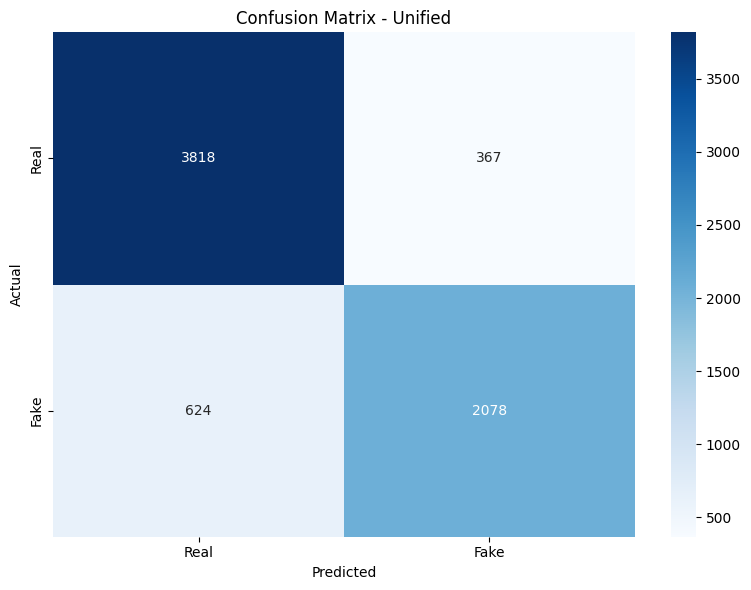


Training completed.


In [5]:
# ======================= CONFIG ========================
datasets = {
    "Unified": {
        "train": "./unified_dataset/train.csv",
        "val": "./unified_dataset/val.csv",
        "test": "./unified_dataset/test.csv"
    }
}

# =================== HELPER FUNCTIONS ===================
def prep_df(df):
    df = df[['tweet', 'label']].copy()
    df.columns = ['Text', 'Label']
    df['Label'] = df['Label'].map({'real': 0, 'fake': 1})
    return df

def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['Text']), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    labels = torch.tensor(df['Label'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

def evaluate_model(model, val_loader, loss_fn):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.inference_mode():
        for batch in tqdm(val_loader, desc="Evaluating", leave=True):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attn_mask, labels = batch
            outputs = model(input_ids, attention_mask=attn_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return avg_loss, acc, prec, rec, f1, all_preds, all_labels

# =================== MAIN TRAINING LOOP ===================
def main():
    os.makedirs(output_base, exist_ok=True)

    for dataset_name, dataset_paths in datasets.items():
        print(f"\n ------ Training fresh model on: {dataset_name} ------ ")
    
        # Load and prepare data
        train_df = prep_df(pd.read_csv(dataset_paths["train"]))
        val_df = prep_df(pd.read_csv(dataset_paths["val"]))
        test_df = prep_df(pd.read_csv(dataset_paths["test"]))

        # No class weight
        loss_fn = torch.nn.CrossEntropyLoss()
        print("Training without class weights.")

        tokenizer = RobertaTokenizer.from_pretrained(base_model)
        train_data = encode_data(train_df, tokenizer)
        val_data = encode_data(val_df, tokenizer)
        test_data = encode_data(test_df, tokenizer)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size)
        test_loader = DataLoader(test_data, batch_size=batch_size)

        model = RobertaForSequenceClassification.from_pretrained(base_model, num_labels=2).to(device)

        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
        total_steps = len(train_loader) * num_epochs
        warmup_steps = int(0.1 * total_steps)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        best_val_acc = 0.0
        patience_counter = 0
        best_model_state = None

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            model.train()
            total_train_loss = 0

            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
                batch = tuple(t.to(device) for t in batch)
                input_ids, attn_mask, labels = batch
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attn_mask)
                loss = loss_fn(outputs.logits, labels)
                loss.backward()
                total_train_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_train_loss / len(train_loader)
            print(f"Training Loss: {avg_train_loss:.4f}")

            val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate_model(model, val_loader, loss_fn)
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Validation Precision: {val_prec:.4f}")
            print(f"Validation Recall: {val_rec:.4f}")
            print(f"Validation F1-score: {val_f1:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = model.state_dict()
                print("New best model found.")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{early_stopping_patience}")
                if patience_counter >= early_stopping_patience:
                    print("Early stopping.")
                    break

        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            os.makedirs(output_base, exist_ok=True)
            torch.save(best_model_state, f"{output_base}/{dataset_name}_model.pt")
            print(f"Best model saved to {output_base}/{dataset_name}_model.pt")

        # Evaluation on Test Set
        test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate_model(model, test_loader, loss_fn)
        print(f"\nTest Set of {dataset_name}:")
        print(f"  Loss:     {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.4f}")
        print(f"  Precision:{test_prec:.4f}")
        print(f"  Recall:   {test_rec:.4f}")
        print(f"  F1-score: {test_f1:.4f}")

        cm = confusion_matrix(test_labels, test_preds)
        cm_df = pd.DataFrame(cm, index=["Real", "Fake"], columns=["Real", "Fake"])
        print("\nConfusion Matrix:")

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{output_base}/{dataset_name}_cm.png', dpi=200)
        plt.close()

        model_dir = os.path.join(output_base, f"{dataset_name}_checkpoint")
        os.makedirs(model_dir, exist_ok=True)
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)

    print("\nTraining completed.")

if __name__ == "__main__":
    main()